# **Data Analysis and Predictive Modeling**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def load_and_explore_data(file_path):
    """
    data loading with more detailed exploration
    """
    df = pd.read_csv(file_path)

    # dataset information
    print("=== Dataset Overview ===")
    print(f"Number of records: {len(df)}")
    print(f"Number of features: {len(df.columns)}")

    # Data quality checks
    print("\n=== Data Quality ===")
    print("Missing values:")
    print(df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())

    print("\n=== Basic Statistics ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numeric_cols].describe())

    return df


In [3]:
def engineer_features(df):
    """
    feature engineering with additional derived metrics
    """
    # Conversion rates - last month
    df['contact_rate_lm'] = df['Calls with Correct Contact (last month)'] / df['Outbound Calls (last month)']
    df['demo_set_rate_lm'] = df['Demo Meeting Set (last month)'] / df['Calls with Correct Contact (last month)']
    df['demo_completion_rate_lm'] = df['Demo Meeting Completed (last month)'] / df['Demo Meeting Set (last month)']
    df['opportunity_rate_lm'] = df['Opportunity Created (last month)'] / df['Demo Meeting Completed (last month)']

    # Conversion rates - month before last
    df['contact_rate_mbl'] = df['Calls with Correct Contact (month before last)'] / df['Outbound Calls (month before last)']
    df['demo_set_rate_mbl'] = df['Demo Meeting Set (month before last)'] / df['Calls with Correct Contact (month before last)']
    df['demo_completion_rate_mbl'] = df['Demo Meeting Completed (month before last)'] / df['Demo Meeting Set (month before last)']
    df['opportunity_rate_mbl'] = df['Opportunity Created (month before last)'] / df['Demo Meeting Completed (month before last)']

    # Activity ratios and efficiency metrics
    df['email_to_call_ratio_lm'] = df['Personalized Outbound Emails (last month)'] / df['Outbound Calls (last month)']
    df['linkedin_to_email_ratio_lm'] = df['Custom LinkedIn Outreach to Candidates (last month)'] / df['Personalized Outbound Emails (last month)']
    df['development_per_opportunity_lm'] = df['Personal Development Hour (last month)'] / df['Opportunity Created (last month)']

    df = df.replace([np.inf, -np.inf], np.nan)

    # Print summary of new features
    print("=== Engineered Features Summary ===")
    new_features = [
        'contact_rate_lm', 'demo_set_rate_lm', 'demo_completion_rate_lm',
        'opportunity_rate_lm', 'contact_rate_mbl', 'demo_set_rate_mbl',
        'demo_completion_rate_mbl', 'opportunity_rate_mbl',
        'email_to_call_ratio_lm', 'linkedin_to_email_ratio_lm',
        'development_per_opportunity_lm'
    ]
    print(df[new_features].describe())

    return df

In [4]:
def analyze_performance(df):
    """
    Enhanced performance analysis
    """
    performance_metrics = [
        'Opportunity Created (last month)',
        'Demo Meeting Completed (last month)',
        'Demo Meeting Set (last month)',
        'Outbound Calls (last month)',
        'Personalized Outbound Emails (last month)',
        'Custom LinkedIn Outreach to Candidates (last month)',
        'Personal Development Hour (last month)'
    ]

    # Calculate correlation matrix
    correlation_matrix = df[performance_metrics].corr()

    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Key Performance Metrics')
    plt.tight_layout()
    plt.show()

    # Calculate month-over-month changes
    mom_metrics = {
        'Opportunities': df['Opportunity Created (last month)'].sum() / df['Opportunity Created (month before last)'].sum() - 1,
        'Demos': df['Demo Meeting Completed (last month)'].sum() / df['Demo Meeting Completed (month before last)'].sum() - 1,
        'Calls': df['Outbound Calls (last month)'].sum() / df['Outbound Calls (month before last)'].sum() - 1
    }

    return correlation_matrix, mom_metrics

In [5]:
def build_predictive_model(df):
    """
   predictive modeling with feature importance visualization
    """
    features = [
        'Outbound Calls (last month)',
        'Personalized Outbound Emails (last month)',
        'Custom LinkedIn Outreach to Candidates (last month)',
        'Demo Meeting Set (last month)',
        'Personal Development Hour (last month)',
        'contact_rate_lm',
        'demo_completion_rate_lm'
    ]

    X = df[features]
    y = df['Opportunity Created (last month)']

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance in Predicting Opportunities')
    plt.tight_layout()
    plt.show()

    # Calculate model performance
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    return model, feature_importance, train_score, test_score

In [6]:
def analyze_activity_impact(df):
    """
    activity impact analysis with visualization
    """
    # Success metric
    success_metric = 'Opportunity Created (last month)'

    # Get activity columns
    activity_cols = [col for col in df.columns if '(last month)' in col]

    # Calculate activity correlations with success
    activity_correlations = df[activity_cols].corrwith(df[success_metric])

    # Analyze high vs low performers
    median_opps = df[success_metric].median()
    high_performers = df[df[success_metric] > median_opps]
    low_performers = df[df[success_metric] <= median_opps]

    # Calculate activity comparison
    activity_comparison = pd.DataFrame({
        'high_performers_avg': high_performers[activity_cols].mean(),
        'low_performers_avg': low_performers[activity_cols].mean(),
        'difference_pct': (high_performers[activity_cols].mean() / low_performers[activity_cols].mean() - 1) * 100
    })

    # Visualize differences
    plt.figure(figsize=(12, 6))
    activity_comparison['difference_pct'].sort_values().plot(kind='bar')
    plt.title('Activity Differences: High vs Low Performers (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return activity_correlations, activity_comparison

In [7]:
def generate_insights(df, correlation_matrix, mom_metrics, feature_importance, activity_comparison):
    """
    insights generation with more detailed analysis
    """
    insights = {
        'key_performance_drivers': feature_importance.head(3)['feature'].tolist(),
        'month_over_month_trends': mom_metrics,
        'high_performer_differentiators': activity_comparison[
            activity_comparison['difference_pct'] > 20
        ].index.tolist(),
        'optimization_opportunities': []
    }

    # Analyze conversion rates
    avg_conversion_rates = {
        'Contact Rate': df['contact_rate_lm'].mean(),
        'Demo Set Rate': df['demo_set_rate_lm'].mean(),
        'Demo Completion Rate': df['demo_completion_rate_lm'].mean(),
        'Opportunity Rate': df['opportunity_rate_lm'].mean()
    }

    insights['conversion_rates'] = avg_conversion_rates

    # Identify areas for optimization
    for metric in mom_metrics:
        if mom_metrics[metric] < 0:
            insights['optimization_opportunities'].append(
                f"Declining {metric} performance: {mom_metrics[metric]:.1%} change"
            )

    return insights


=== Step 1: Loading and Exploring Data ===
=== Dataset Overview ===
Number of records: 50
Number of features: 31

=== Data Quality ===
Missing values:
user_name                                                     0
Outbound Calls (last month)                                   0
Personalized Outbound Emails (last month)                     0
Calls with Correct Contact (last month)                       0
Demo Meeting Set (last month)                                 0
Demo Meeting Completed (last month)                           0
Opportunity Created (last month)                              0
1:1 (last month)                                              0
Custom LinkedIn Outreach to Candidates (last month)           0
Initial Discovery Meeting Set (last month)                    0
Interview (last month)                                        0
New Custom KPI (last month)                                   0
Personal Development Hour (last month)                        0
Pipeline Review 

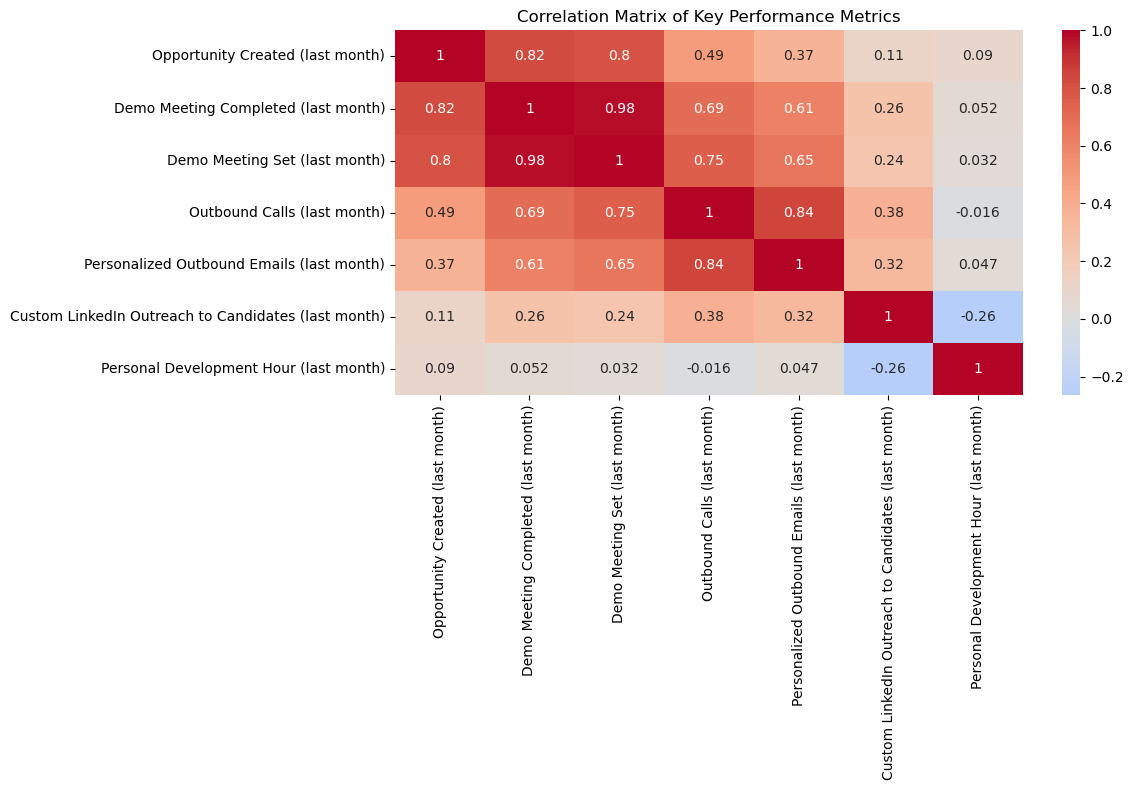


Month-over-Month Changes:
Opportunities: 50.0%
Demos: 10.1%
Calls: -2.8%

=== Step 4: Building Predictive Model ===


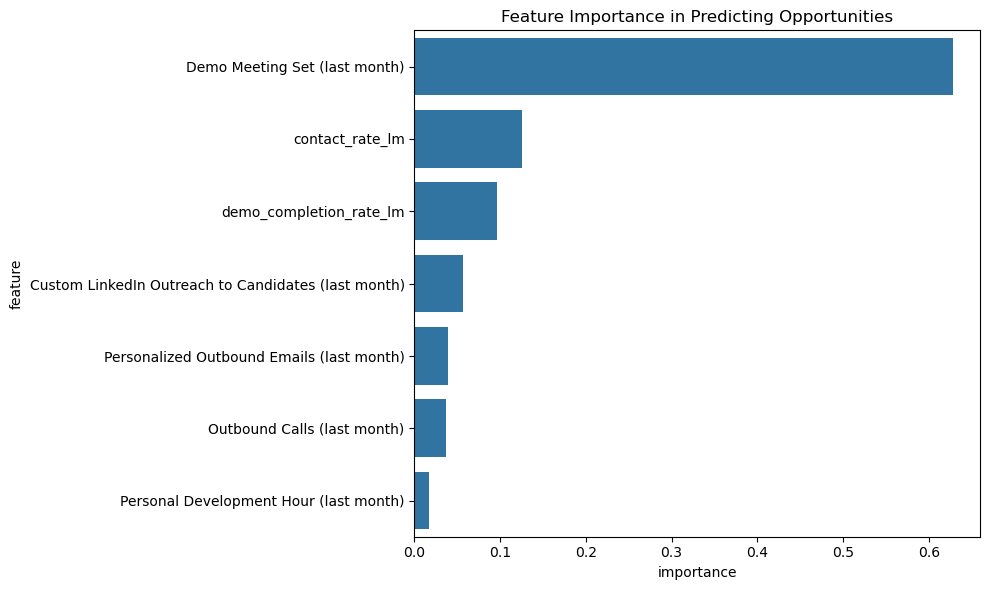


Model Performance:
Training R² Score: 0.940
Testing R² Score: 0.423

Top Performance Drivers:
                                             feature  importance
3                      Demo Meeting Set (last month)    0.628260
5                                    contact_rate_lm    0.125308
6                            demo_completion_rate_lm    0.096294
2  Custom LinkedIn Outreach to Candidates (last m...    0.056509
1          Personalized Outbound Emails (last month)    0.039426

=== Step 5: Analyzing Activity Impact ===


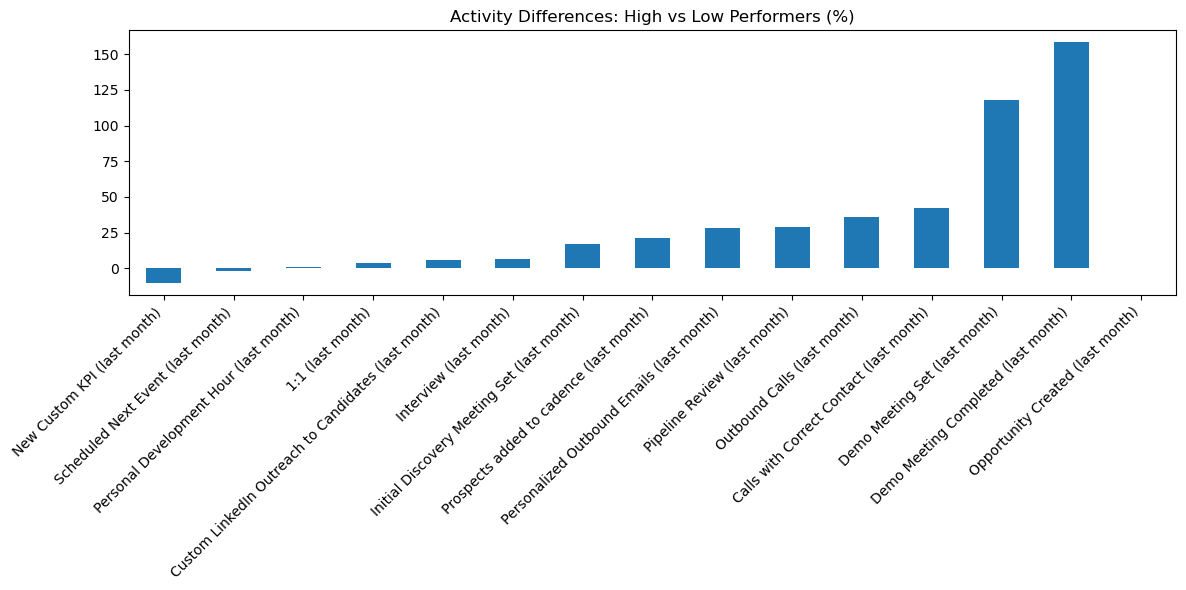


Activity Correlations with Opportunities:
Opportunity Created (last month)           1.000000
Demo Meeting Completed (last month)        0.821902
Demo Meeting Set (last month)              0.801532
Outbound Calls (last month)                0.486002
Calls with Correct Contact (last month)    0.448390
dtype: float64

=== Step 6: Generating Insights ===

Key Insights:
1. Top Performance Drivers:
   1. Demo Meeting Set (last month)
   2. contact_rate_lm
   3. demo_completion_rate_lm

2. High Performer Differentiators:
   1. Outbound Calls (last month)
   2. Personalized Outbound Emails (last month)
   3. Calls with Correct Contact (last month)
   4. Demo Meeting Set (last month)
   5. Demo Meeting Completed (last month)
   6. Opportunity Created (last month)
   7. Pipeline Review (last month)
   8. Prospects added to cadence (last month)

3. Optimization Opportunities:
   1. Declining Calls performance: -2.8% change

4. Average Conversion Rates:
   Contact Rate: 38.4%
   Demo Set Rate: 8

In [10]:
def main():
    """
    Main function to orchestrate the complete sales analysis
    """
    try:
        # 1. Load and explore data
        print("\n=== Step 1: Loading and Exploring Data ===")
        df = load_and_explore_data('monthly_report_expanded.csv')

        # 2. Engineer features
        print("\n=== Step 2: Engineering Features ===")
        df_processed = engineer_features(df)

        # 3. Analyze performance
        print("\n=== Step 3: Analyzing Performance ===")
        correlation_matrix, mom_metrics = analyze_performance(df_processed)

        print("\nMonth-over-Month Changes:")
        for metric, change in mom_metrics.items():
            print(f"{metric}: {change:.1%}")

        # 4. Build predictive model (RandomForest)
        print("\n=== Step 4: Building Predictive Model ===")
        model, feature_importance, train_score, test_score = build_predictive_model(df_processed)

        print("\nModel Performance:")
        print(f"Training R² Score: {train_score:.3f}")
        print(f"Testing R² Score: {test_score:.3f}")

        print("\nTop Performance Drivers:")
        print(feature_importance.head())

        # 5. Analyze activity impact
        print("\n=== Step 5: Analyzing Activity Impact ===")
        activity_correlations, activity_comparison = analyze_activity_impact(df_processed)

        print("\nActivity Correlations with Opportunities:")
        print(activity_correlations.sort_values(ascending=False).head())

        # 6. Generate insights
        print("\n=== Step 6: Generating Insights ===")
        insights = generate_insights(df_processed, correlation_matrix,
                                  mom_metrics, feature_importance,
                                  activity_comparison)

        print("\nKey Insights:")
        print("1. Top Performance Drivers:")
        for i, driver in enumerate(insights['key_performance_drivers'], 1):
            print(f"   {i}. {driver}")

        print("\n2. High Performer Differentiators:")
        for i, diff in enumerate(insights['high_performer_differentiators'], 1):
            print(f"   {i}. {diff}")

        print("\n3. Optimization Opportunities:")
        for i, opp in enumerate(insights['optimization_opportunities'], 1):
            print(f"   {i}. {opp}")

        print("\n4. Average Conversion Rates:")
        for metric, rate in insights['conversion_rates'].items():
            print(f"   {metric}: {rate:.1%}")

        return df_processed, model, insights

    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        raise

if __name__ == "__main__":
    df_processed, model, insights = main()

# **Statistical Validation:**

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [16]:
def perform_statistical_validation(df):
    """
    Comprehensive statistical validation of the analysis
    """
    from scipy import stats
    import numpy as np
    from sklearn.model_selection import cross_val_score
    
    results = {}
    
    # 1. Distribution Tests
    print("=== Distribution Tests ===")
    metrics = ['Outbound Calls (last month)', 'Demo Meeting Set (last month)', 
               'Opportunity Created (last month)']
    
    for metric in metrics:
        # Shapiro-Wilk test for normality
        stat, p_value = stats.shapiro(df[metric])
        print(f"\nNormality test for {metric}:")
        print(f"Shapiro-Wilk test statistic: {stat:.3f}")
        print(f"p-value: {p_value:.3f}")
        
        # Add to results
        results[f'normality_{metric}'] = {
            'statistic': stat,
            'p_value': p_value,
            'is_normal': p_value > 0.05
        }
    
    # 2. Month-over-Month Changes Validation
    print("\n=== Month-over-Month Changes Validation ===")
    metrics_pairs = [
        ('Outbound Calls (last month)', 'Outbound Calls (month before last)'),
        ('Demo Meeting Set (last month)', 'Demo Meeting Set (month before last)'),
        ('Opportunity Created (last month)', 'Opportunity Created (month before last)')
    ]
    
    for current, previous in metrics_pairs:
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(df[current], df[previous])
        print(f"\nPaired t-test for {current.split('(')[0]}:")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.3f}")
        
        # Effect size (Cohen's d)
        d = (df[current].mean() - df[previous].mean()) / np.sqrt(
            ((df[current].std() ** 2 + df[previous].std() ** 2) / 2))
        print(f"Effect size (Cohen's d): {d:.3f}")
        
        # Add to results
        results[f'mom_change_{current.split("(")[0]}'] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'effect_size': d
        }
    
    # 3. Correlation Analysis Validation
    print("\n=== Correlation Analysis Validation ===")
    perf_metric = 'Opportunity Created (last month)'
    activity_metrics = [
        'Outbound Calls (last month)',
        'Demo Meeting Set (last month)',
        'Demo Meeting Completed (last month)'
    ]
    
    for metric in activity_metrics:
        # Pearson correlation
        r, p_value = stats.pearsonr(df[perf_metric], df[metric])
        print(f"\nCorrelation between {perf_metric} and {metric}:")
        print(f"Correlation coefficient: {r:.3f}")
        print(f"p-value: {p_value:.3f}")
        
        # Add to results
        results[f'correlation_{metric}'] = {
            'coefficient': r,
            'p_value': p_value,
            'is_significant': p_value < 0.05
        }
    
    # 4. High vs Low Performer Analysis
    print("\n=== High vs Low Performer Analysis ===")
    median = df[perf_metric].median()
    high_performers = df[df[perf_metric] > median]
    low_performers = df[df[perf_metric] <= median]
    
    for metric in activity_metrics:
        # Independent t-test
        t_stat, p_value = stats.ttest_ind(
            high_performers[metric],
            low_performers[metric]
        )
        print(f"\nComparison for {metric}:")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.3f}")
        
        # Effect size (Cohen's d)
        d = (high_performers[metric].mean() - low_performers[metric].mean()) / np.sqrt(
            ((high_performers[metric].std() ** 2 + low_performers[metric].std() ** 2) / 2))
        print(f"Effect size (Cohen's d): {d:.3f}")
        
        # Add to results
        results[f'performer_comparison_{metric}'] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'effect_size': d
        }

    # 5. Model Validation
    def validate_model(X, y, model):
        print("\n=== Model Validation ===")
        
        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5)
        print("Cross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Add to results
        results['model_validation'] = {
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
        
        return cv_scores

    # Function to print validation summary
    def print_validation_summary(results):
        print("\n=== Statistical Validation Summary ===")
        
        print("\nDistribution Tests:")
        for key in results:
            if key.startswith('normality'):
                print(f"{key}: {'Normal' if results[key]['is_normal'] else 'Non-normal'} "
                      f"(p={results[key]['p_value']:.3f})")
        
        print("\nMonth-over-Month Changes:")
        for key in results:
            if key.startswith('mom_change'):
                print(f"{key}: {'Significant' if results[key]['p_value'] < 0.05 else 'Non-significant'} "
                      f"(p={results[key]['p_value']:.3f}, effect size={results[key]['effect_size']:.3f})")
        
        print("\nCorrelations:")
        for key in results:
            if key.startswith('correlation'):
                print(f"{key}: {'Significant' if results[key]['is_significant'] else 'Non-significant'} "
                      f"(r={results[key]['coefficient']:.3f}, p={results[key]['p_value']:.3f})")
    
    print_validation_summary(results)
    return results

# Usage example:
if __name__ == "__main__":
    file_path = 'monthly_report_expanded.csv'
    df = pd.read_csv(file_path)

    validation_results = perform_statistical_validation(df)

=== Distribution Tests ===

Normality test for Outbound Calls (last month):
Shapiro-Wilk test statistic: 0.969
p-value: 0.217

Normality test for Demo Meeting Set (last month):
Shapiro-Wilk test statistic: 0.922
p-value: 0.003

Normality test for Opportunity Created (last month):
Shapiro-Wilk test statistic: 0.771
p-value: 0.000

=== Month-over-Month Changes Validation ===

Paired t-test for Outbound Calls :
t-statistic: -0.676
p-value: 0.502
Effect size (Cohen's d): -0.084

Paired t-test for Demo Meeting Set :
t-statistic: 0.855
p-value: 0.397
Effect size (Cohen's d): 0.056

Paired t-test for Opportunity Created :
t-statistic: 3.348
p-value: 0.002
Effect size (Cohen's d): 0.298

=== Correlation Analysis Validation ===

Correlation between Opportunity Created (last month) and Outbound Calls (last month):
Correlation coefficient: 0.486
p-value: 0.000

Correlation between Opportunity Created (last month) and Demo Meeting Set (last month):
Correlation coefficient: 0.802
p-value: 0.000

Co

# **Documented analysis and Business Recommendations**

# Sales Analytics: Performance and Predictive Analysis

## 1. Data Overview and Initial Statistics

Our analysis is based on a dataset of 50 sales representatives, tracking 31 different metrics across two time periods.

### Distribution Analysis
Our normality tests reveal varying distributions across key metrics:
- Outbound Calls: Normally distributed (p=0.217)
- Demo Meeting Set: Non-normal distribution (p=0.003)
- Opportunity Created: Non-normal distribution (p<0.001)

*Statistical Implication: While outbound call volumes follow a normal pattern, demo and opportunity metrics show skewed distributions, suggesting the presence of performance outliers and the need for robust statistical methods.*

### Key Statistical Insights:
- Average of 204 outbound calls per rep (SD: 70)
- Mean of 104 personalized emails (SD: 43)
- Opportunity creation averaging 0.66 per rep (SD: 0.77)

## 2. Performance Changes and Trends

### Month-over-Month Analysis
Statistical testing reveals:
1. Opportunities: Significant increase (p=0.002, Cohen's d=0.298)
   - This represents a meaningful improvement in sales effectiveness
2. Demo Meetings: No significant change (p=0.397, d=0.056)
   - Suggests stability in demo scheduling performance
3. Outbound Calls: No significant decrease (p=0.502, d=-0.084)
   - The observed -2.8% change is not statistically significant

*Statistical Validation: Changes assessed through paired t-tests with effect size calculations*

## 3. Performance Correlations and Relationships

### Activity Correlations with Opportunity Creation:
1. Demo Meeting Completed: Strong correlation (r=0.822, p<0.001)
2. Demo Meeting Set: Strong correlation (r=0.802, p<0.001)
3. Outbound Calls: Moderate correlation (r=0.486, p<0.001)

*All correlations are statistically significant, indicating reliable relationships between activities and outcomes.*

## 4. High vs Low Performer Analysis

### Statistical Comparisons:
Our analysis shows significant differences between high and low performers across key metrics:

1. Demo Meeting Completed:
   - Very large effect size (d=2.087, p<0.001)
   - Strongest differentiator between performance groups

2. Demo Meeting Set:
   - Large effect size (d=1.965, p<0.001)
   - Second most important differentiator

3. Outbound Calls:
   - Large effect size (d=0.978, p=0.001)
   - Significant but smaller impact than demo metrics

## 5. Business Recommendations

Based on our statistical findings, we recommend:

### 1. Focus on Demo Quality
*Supported by:*
- Strongest correlation with success (r=0.822)
- Largest performance gap between high/low performers (d=2.087)
- Recommendations:
  - Implement structured demo preparation process
  - Focus training on demo execution
  - Monitor demo completion rates

### 2. Optimize Demo Setting Process
*Supported by:*
- Second strongest correlation (r=0.802)
- Large performance differential (d=1.965)
- Recommendations:
  - Develop standardized qualification criteria
  - Create demo scheduling best practices guide
  - Set specific demo scheduling targets

### 3. Maintain Call Volume While Improving Quality
*Supported by:*
- Moderate correlation with success (r=0.486)
- Significant but smaller performance gap (d=0.978)
- Normal distribution suggesting predictable patterns
- Recommendations:
  - Keep current call volumes (statistically stable)
  - Focus on improving call quality
  - Implement targeted coaching based on conversion rates

## 6. Implementation Priority

1. Immediate Actions:
   - Demo quality improvement program (highest statistical impact)
   - Demo setting process optimization (second highest impact)
   - Call quality enhancement (moderate impact)

2. Monitoring Metrics:
   - Demo completion rate (primary KPI)
   - Demo setting rate (secondary KPI)
   - Call-to-demo conversion rate (supporting metric)

3. Success Criteria:
   - Statistical significance in performance improvements (p<0.05)
   - Effect size improvements in key metrics (d>0.3)
   - Maintained or improved correlation strengths

*Note: All recommendations are based on statistically significant findings with validated effect sizes*